#### Git configs

In [ ]:

username = 'ayodyak'
repo = 'Y2_S1_Batch02_Ku28'

In [ ]:
!git remote set-url origin https://github.com/{username}/{repo}

In [ ]:
!git clone https://github.com/{username}/{repo}

Cloning into 'Y2_S1_Batch02_Ku28'...
remote: Enumerating objects: 71518, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 71518 (delta 1), reused 11 (delta 1), pack-reused 71493 (from 1)
Receiving objects: 100% (71518/71518), 1.43 GiB | 31.62 MiB/s, done.
Resolving deltas: 100% (30/30), done.
Updating files: 100% (71463/71463), done.


In [ ]:
%cd {repo}

/content/Y2_S1_Batch02_Ku28


#### Pre Processing

In [ ]:
import os
from PIL import Image
import numpy as np
from PIL import Image, ImageEnhance
from collections import Counter
import random

In [ ]:

dataset_path = '/content/Y2_S1_Batch02_Ku28/data/technic 1'

# Get only directory names inside Dataset
class_names = [
    name for name in os.listdir(dataset_path)
    if os.path.isdir(os.path.join(dataset_path, name))
]

print(class_names)



['Potato___Late_blight', 'Corn_(maize)___healthy', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Corn_(maize)___Northern_Leaf_Blight', 'Apple___Cedar_apple_rust', 'Pepper__bell___healthy', 'Pepper__bell___Bacterial_spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Tomato_healthy', 'Corn_(maize)___Common_rust_', 'Tomato_Septoria_leaf_spot', 'Tomato_Early_blight', 'Potato___Early_blight', 'Tomato__Tomato_mosaic_virus', 'Apple___Apple_scab', 'Apple___healthy', 'Tomato_Leaf_Mold', 'Tomato_Bacterial_spot', 'Tomato__Target_Spot', 'Apple___Black_rot', 'Potato___healthy', 'Tomato_Late_blight']


In [ ]:


src_root = '/content/Y2_S1_Batch02_Ku28/data/technic 1'
dst_root = '/content/Y2_S1_Batch02_Ku28/data/technic_scale'

# create destination root if not exists
os.makedirs(dst_root, exist_ok=True)

def normalize_image(img: Image.Image) -> Image.Image:
    """Scale pixel values to [0,1] then back to 0–255 as uint8 for saving."""
    arr = np.asarray(img).astype('float32') / 255.0    # scale to [0,1]
    arr = (arr * 255).astype('uint8')                  # back to uint8 for file
    return Image.fromarray(arr)

for class_name in os.listdir(src_root):
    class_path = os.path.join(src_root, class_name)
    if not os.path.isdir(class_path):
        continue

    # make matching class folder in destination
    dst_class_path = os.path.join(dst_root, class_name)
    os.makedirs(dst_class_path, exist_ok=True)

    for file in os.listdir(class_path):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            src_file = os.path.join(class_path, file)
            dst_file = os.path.join(dst_class_path, file)

            img = Image.open(src_file).convert('RGB')
            img_norm = normalize_image(img)
            img_norm.save(dst_file)


In [ ]:
!pip install scikit-image opencv-python matplotlib tqdm


#### Retinex Algorithm

/tmp/ipython-input-3678477199.py:35: RuntimeWarning: invalid value encountered in power
  return np.uint8(255.0 * (img_norm ** (1.0 / gamma)))
/tmp/ipython-input-3678477199.py:35: RuntimeWarning: invalid value encountered in cast
  return np.uint8(255.0 * (img_norm ** (1.0 / gamma)))


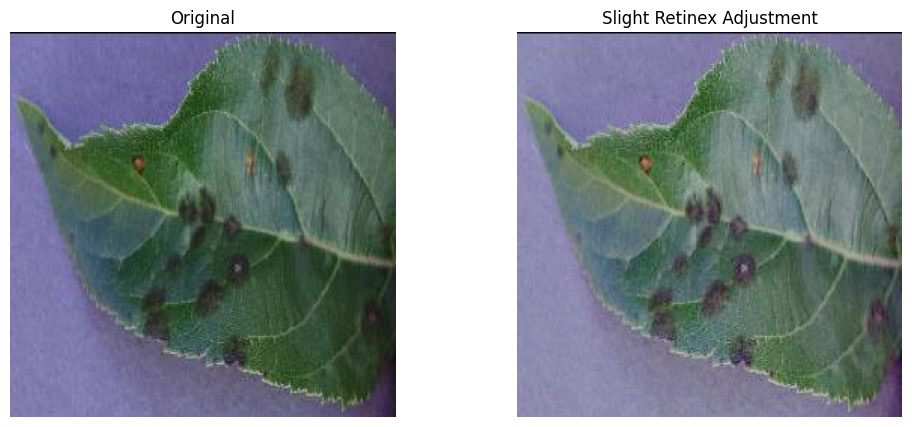

In [ ]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
from tqdm import tqdm

# --- 1. Load image ---
img_path = "/content/Y2_S1_Batch02_Ku28/data/technic_scale/Apple___Apple_scab/01a66316-0e98-4d3b-a56f-d78752cd043f___FREC_Scab 3003_90deg.JPG"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)

# --- 2. Softer Multi-Scale Retinex ---
def multi_scale_retinex(img, sigmas=[15, 40]):
    log_img = np.log10(img + 1.0)
    retinex = np.zeros_like(img)
    for s in sigmas:
        blur = cv2.GaussianBlur(img, (0, 0), s)
        retinex += log_img - np.log10(blur + 1.0)
    retinex /= len(sigmas)
    retinex = cv2.normalize(retinex, None, 0, 255, cv2.NORM_MINMAX)
    return retinex

# --- 3. Simple color balance (very light) ---
def simple_color_balance(img, low_clip=0.5, high_clip=0.5):
    out = np.zeros_like(img)
    for c in range(3):
        flat = img[:, :, c].flatten()
        low_val = np.percentile(flat, low_clip)
        high_val = np.percentile(flat, 100 - high_clip)
        channel = np.clip(img[:, :, c], low_val, high_val)
        out[:, :, c] = cv2.normalize(channel, None, 0, 255, cv2.NORM_MINMAX)
    return out

# --- 4. Mild gamma darkening ---
def gamma_correct(img, gamma=1.3):
    img_norm = img / 255.0
    return np.uint8(255.0 * (img_norm ** (1.0 / gamma)))

# --- 5. Pipeline with blending to keep it subtle ---
retinex = multi_scale_retinex(img)
retinex = simple_color_balance(retinex)

# Blend 70% original + 30% retinex for a slight change
blended = 0.7 * img + 0.18 * retinex
blended = gamma_correct(blended)

# --- 6. Display ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(np.uint8(img))
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(blended.astype(np.uint8))
plt.title("Slight Retinex Adjustment")
plt.axis("off")
plt.show()


In [ ]:


# ---------- Paths ----------
src_root = "/content/Y2_S1_Batch02_Ku28/data/technic_scale"
dst_root = "/content/Y2_S1_Batch02_Ku28/data/processed_retinex"
os.makedirs(dst_root, exist_ok=True)

# ---------- Retinex + blend helpers ----------
def multi_scale_retinex(img, sigmas=[15, 40]):
    log_img = np.log10(img + 1.0)
    retinex = np.zeros_like(img)
    for s in sigmas:
        blur = cv2.GaussianBlur(img, (0, 0), s)
        retinex += log_img - np.log10(blur + 1.0)
    retinex /= len(sigmas)
    retinex = cv2.normalize(retinex, None, 0, 255, cv2.NORM_MINMAX)
    return retinex

def simple_color_balance(img, low_clip=0.5, high_clip=0.5):
    out = np.zeros_like(img)
    for c in range(3):
        flat = img[:, :, c].flatten()
        low_val = np.percentile(flat, low_clip)
        high_val = np.percentile(flat, 100 - high_clip)
        channel = np.clip(img[:, :, c], low_val, high_val)
        out[:, :, c] = cv2.normalize(channel, None, 0, 255, cv2.NORM_MINMAX)
    return out

def gamma_correct(img, gamma=1.3):
    img_norm = img / 255.0
    return np.uint8(255.0 * (img_norm ** (1.0 / gamma)))

def gentle_retinex(img):
    r = multi_scale_retinex(img)
    r = simple_color_balance(r)
    blended = 0.7 * img + 0.18 * r    # <-- your preferred blend
    blended = gamma_correct(blended)
    return np.uint8(blended)

# ---------- Process the whole dataset ----------
extensions = ("*.jpg","*.jpeg","*.png","*.JPG","*.JPEG","*.PNG")
image_paths = []
for ext in extensions:
    image_paths.extend(glob(os.path.join(src_root, "**", ext), recursive=True))

for src_path in tqdm(image_paths, desc="Processing images"):
    rel_path = os.path.relpath(src_path, src_root)
    dst_path = os.path.join(dst_root, rel_path)
    os.makedirs(os.path.dirname(dst_path), exist_ok=True)

    img = cv2.imread(src_path)
    if img is None:
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)

    out_img = gentle_retinex(img)

    # Save back to disk as JPEG (RGB→BGR for OpenCV write)
    cv2.imwrite(dst_path, cv2.cvtColor(out_img, cv2.COLOR_RGB2BGR))

print(" All images processed and saved to:", dst_root)


Processing images:   0%|          | 0/35725 [00:00<?, ?it/s]/tmp/ipython-input-1472683154.py:35: RuntimeWarning: invalid value encountered in power
  return np.uint8(255.0 * (img_norm ** (1.0 / gamma)))
/tmp/ipython-input-1472683154.py:35: RuntimeWarning: invalid value encountered in cast
  return np.uint8(255.0 * (img_norm ** (1.0 / gamma)))
Processing images: 100%|██████████| 35725/35725 [26:29<00:00, 22.48it/s]

✅ All images processed and saved to: /content/Y2_S1_Batch02_Ku28/data/processed_retinex


##### EDA Visualization

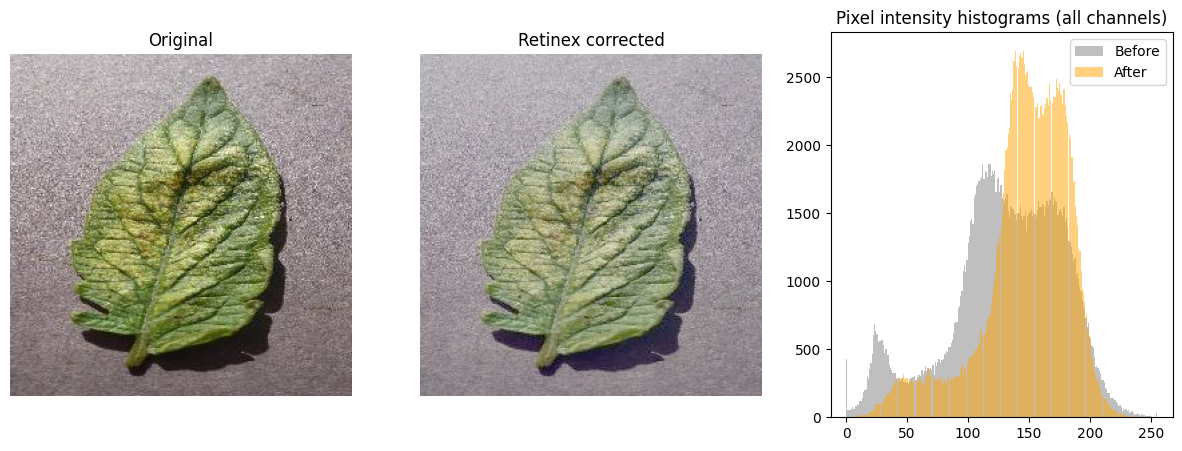

Mean brightness (V channel) - before: 142.9, after: 154.5



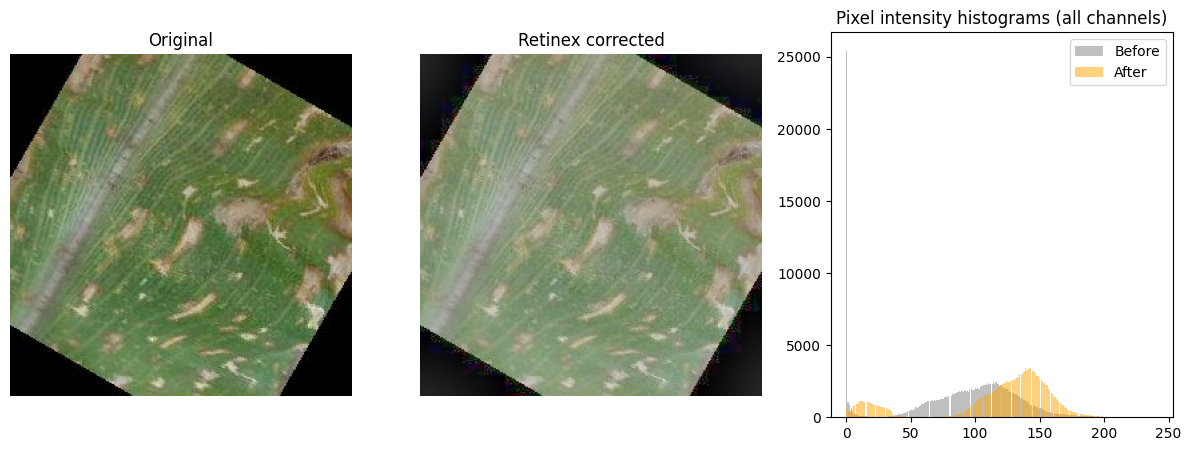

Mean brightness (V channel) - before: 107.6, after: 131.0



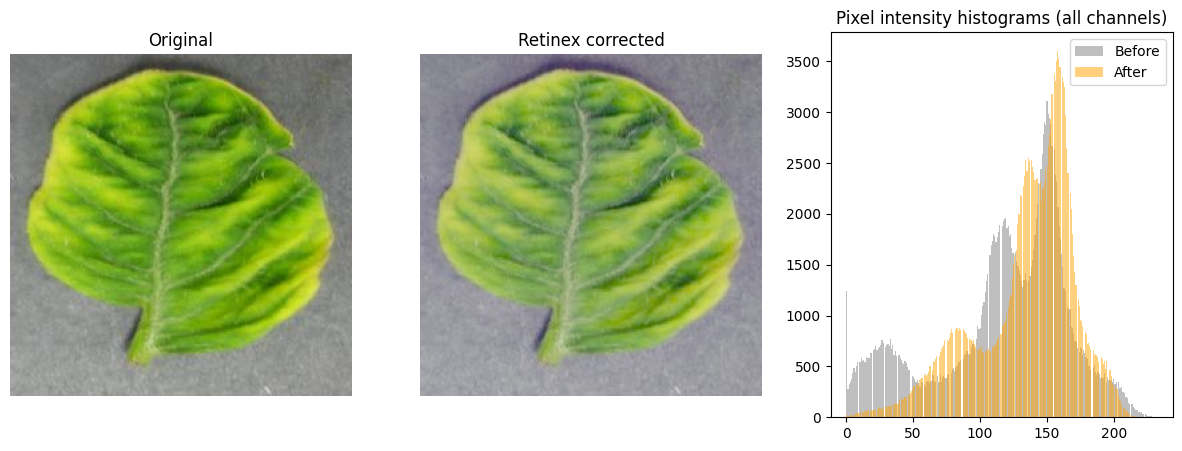

Mean brightness (V channel) - before: 150.9, after: 159.4



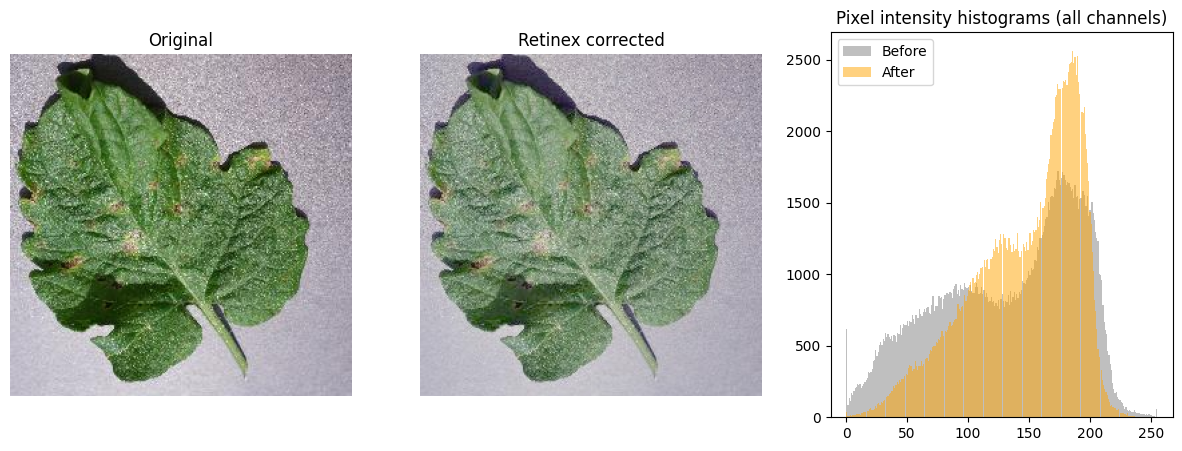

Mean brightness (V channel) - before: 149.2, after: 158.6



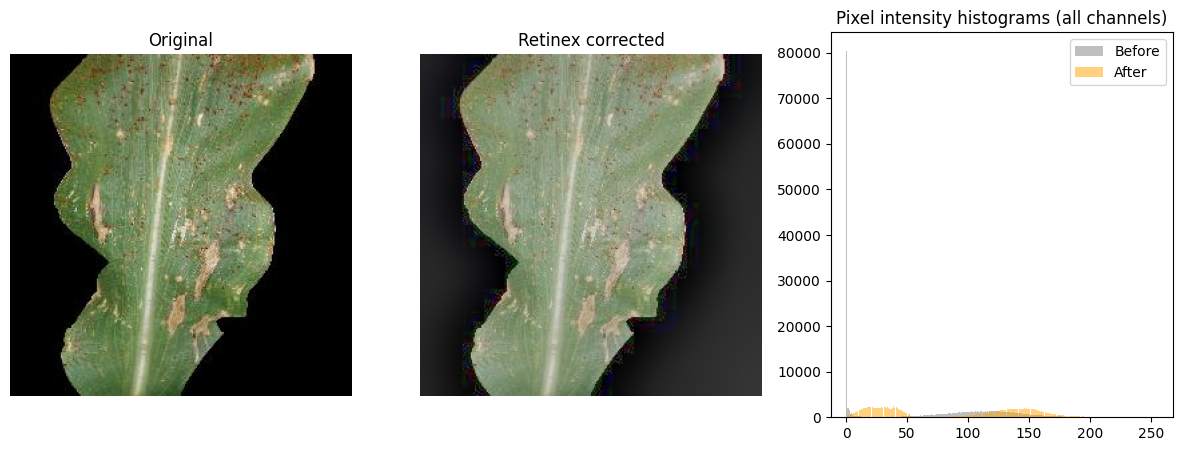

Mean brightness (V channel) - before: 74.9, after: 98.9



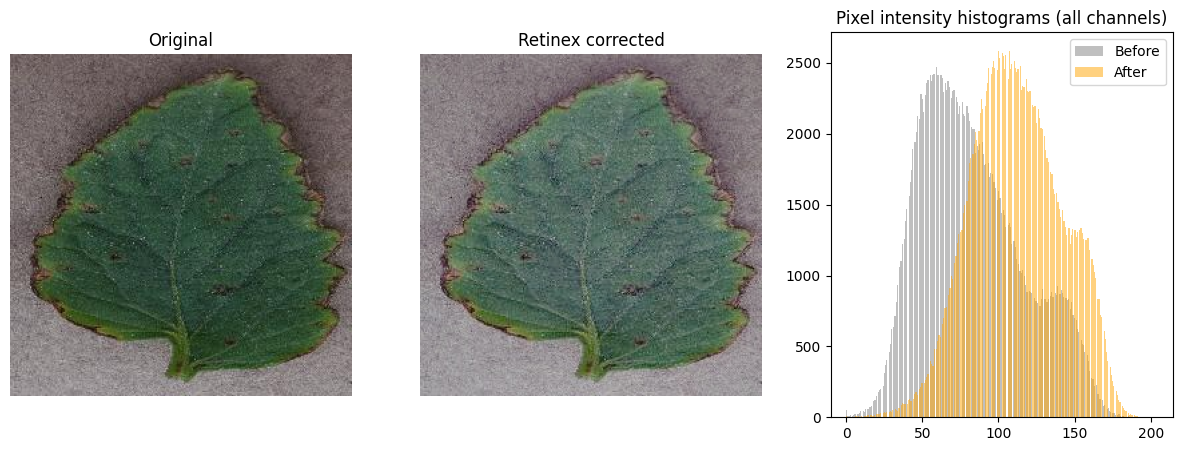

Mean brightness (V channel) - before: 95.4, after: 121.4



In [ ]:
import os, glob, random
import cv2
import numpy as np
import matplotlib.pyplot as plt

src_root = "/content/Y2_S1_Batch02_Ku28/data/raw/Dataset"
dst_root = "/content/Y2_S1_Batch02_Ku28/data/processed_retinex"

def mean_brightness_rgb(img_rgb):
    """Return mean brightness (V channel) of an RGB image."""
    hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    return float(hsv[:, :, 2].mean())

# --- pick random sample images from each class ---
sample_paths = []
for cls in os.listdir(src_root):
    cls_path = os.path.join(src_root, cls)
    if not os.path.isdir(cls_path):
        continue
    imgs = glob.glob(os.path.join(cls_path, '*'))
    jpgs = [p for p in imgs if p.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if jpgs:
        sample_paths.append(random.choice(jpgs))

# --- compare up to 6 samples ---
for src in sample_paths[:6]:
    rel = os.path.relpath(src, src_root)
    dst = os.path.join(dst_root, rel)
    if not os.path.exists(dst):
        continue  # skip if processed file not present

    before = cv2.cvtColor(cv2.imread(src), cv2.COLOR_BGR2RGB)
    after  = cv2.cvtColor(cv2.imread(dst), cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(before); ax[0].set_title('Original'); ax[0].axis('off')
    ax[1].imshow(after);  ax[1].set_title('Retinex corrected'); ax[1].axis('off')

    # Combined RGB histogram
    ax[2].hist(before.ravel(), bins=256, alpha=0.5, label='Before', color='gray')
    ax[2].hist(after.ravel(),  bins=256, alpha=0.5, label='After',  color='orange')
    ax[2].set_title('Pixel intensity histograms (all channels)')
    ax[2].legend()
    plt.show()

    print("Mean brightness (V channel) - before: {:.1f}, after: {:.1f}\n"
          .format(mean_brightness_rgb(before), mean_brightness_rgb(after)))
